Imports

In [7]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd
import time

Using TensorFlow backend.


In [8]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

## Baseline LSTM + room to change network architecture

In [9]:
def handle_wind_dir(data):
    '''
    Different ways to handle the string format:
     1. Drop it
     2. LabelEncode it
     3. One-hot encode it
     
    The reason I need to handle it is because Keras' pad_sequences function takes int() of
    all the columns.
    '''
    # I'll drop it first
    data = data.drop('wnd_dir', axis=1, inplace=False)
    return data

In [10]:
import warnings; warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv('../data/pollution.csv', header=0, index_col=0)

In [12]:
df.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow',
       'rain'],
      dtype='object')

In [13]:
# Optionally drop wind dir
df = handle_wind_dir(df)

In [14]:
def plot_training_set(df, train_size=0.08, column='pollution'):
    '''
    Plots the time series of the pollution in the training set
    '''
    row = round(train_size * len(df))
    train = df.iloc[:int(row), :]
    pd.DataFrame(train[column], columns=[column]).plot(figsize=(17,2),
                                                      )

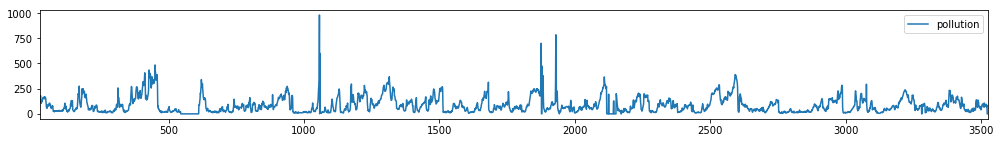

In [15]:
plot_training_set(df, column='pollution')

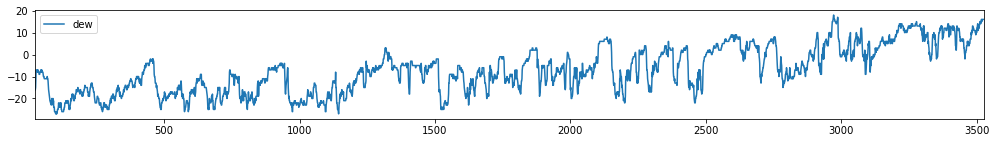

In [16]:
plot_training_set(df, column='dew')

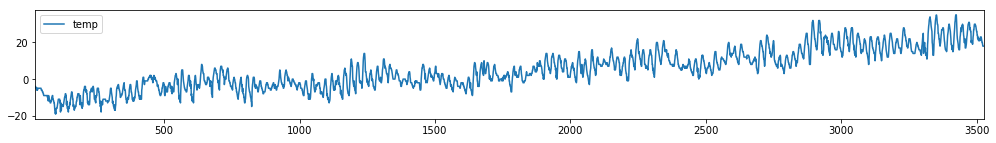

In [17]:
plot_training_set(df, column='temp')

In [18]:
#train, test = train_test_split(df, test_size=.20, random_state=789)

In [36]:
def split_ordered_train_test(df, test_size=.20):
    row = round((1 - test_size) * len(df))
    print(row)
    train = df.iloc[:int(row), :]
    test = df.iloc[int(row):, :].reset_index(drop=True)
    return train, test

In [37]:
train, test = split_ordered_train_test(df)

35040


In [38]:
len(train)

35040

In [39]:
len(test)

8760

In [44]:
#plot_training_set(train, )

In [45]:
def prepare_sequences(df):
    ''' 
    Let df = train and prepare sequences.
    '''
    input_cols = list(df.columns)
    df['single_input_vector'] = df[input_cols].apply(tuple, axis=1).apply(list)\
        .apply(lambda x: [list(x)])
    df['single_output_vector'] = df['pollution'].apply(lambda x: [[x]])
    return df.reset_index(drop=True)

In [46]:
train = prepare_sequences(train)

In [47]:
train.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,single_input_vector,single_output_vector
0,129.0,-16,-4.0,1020.0,1.79,0,0,"[[129.0, -16.0, -4.0, 1020.0, 1.79, 0.0, 0.0]]",[[129.0]]
1,148.0,-15,-4.0,1020.0,2.68,0,0,"[[148.0, -15.0, -4.0, 1020.0, 2.68, 0.0, 0.0]]",[[148.0]]
2,159.0,-11,-5.0,1021.0,3.57,0,0,"[[159.0, -11.0, -5.0, 1021.0, 3.57, 0.0, 0.0]]",[[159.0]]
3,181.0,-7,-5.0,1022.0,5.36,1,0,"[[181.0, -7.0, -5.0, 1022.0, 5.36, 1.0, 0.0]]",[[181.0]]
4,138.0,-7,-5.0,1022.0,6.25,2,0,"[[138.0, -7.0, -5.0, 1022.0, 6.25, 2.0, 0.0]]",[[138.0]]


In [48]:
def func(x, maxlen=None):
    '''
    Pad sequences with lists of 0s. Functional lambda programming.
    '''
    zeros_to_add = maxlen - len(x)
    prepended = [np.zeros(7).tolist()]
    y = prepended*zeros_to_add + x
    return y

def func_output(x, maxlen=None):
    '''
    Pad sequences with lists of 0s. Functional lambda programming.
    '''
    zeros_to_add = maxlen - len(x)
    prepended = [np.zeros(1).tolist()]
    y = prepended*zeros_to_add + x
    return y

def balanced_sliding_windows(df, stride=3):
    '''
    Create sliding windows of size [n - 3, n + 3]. Let df=train.
    '''
    seqs = []
    for i, value in df.iterrows():
        if i >= stride and i < len(df) - stride:
            sequences = df.iloc[i-stride:i+stride, -1].sum()
        elif i < stride:
            sequences = df.iloc[i:i+stride, -1].sum()
        else:
            sequences = df.iloc[i-stride:i, -1].sum()
        seqs.append(sequences)
    return pd.Series(seqs)
        
def past_windows(df, stride=3):
    '''
    Create windows of size [n - 3: n]. Let df=train.
    '''
    seqs = []
    for i, value in df.iterrows():
        if i >= stride and i < len(df) - stride:
            sequences = df.iloc[i-stride:i, -1].sum()
        elif i < stride:
            sequences = df.iloc[0:i, -1].sum()
        else:
            sequences = df.iloc[i-stride:i, -1].sum()
        if sequences == 0:
            # Pad empty array with arrays of 0s
            sequences = func([], stride)
        if len(sequences) < stride:
            # Pad with arrays of 0s
            sequences = func(sequences, stride)
        seqs.append(sequences)
    return pd.Series(seqs)

def future_windows(df, stride=3):
    '''
    Create windows of size [n : n+3]. Let df=train.
    '''
    seqs = []
    for i, value in df.iterrows():
        if i >= stride and i < len(df) - stride:
            sequences = df.iloc[i:i+stride, -1].sum()
        elif i < stride:
            sequences = df.iloc[i:i+stride, -1].sum()
        else:
            sequences = df.iloc[i:, -1].sum()
        if type(sequences) == 'int' and sequences == 0:
            sequences = func_output([], stride)
        if len(sequences) < stride:
            # Pad with arrays of 0s
            sequences = func_output(sequences, stride)
        seqs.append(sequences)
    return pd.Series(seqs)

In [49]:
input_vec = train['single_input_vector']
input_vec = pd.DataFrame(input_vec)

In [50]:
output_vec = train['single_output_vector']
output_vec = pd.DataFrame(output_vec)

In [19]:
# Good so far.

In [20]:
#balanced_sliding_windows(input_vec).head()

In [21]:
#past_windows(input_vec).head()

In [22]:
#future_windows(output_vec).head()

In [23]:
#df.head()

In [24]:
# Good so far

In [51]:
train['past_sequences'] = past_windows(input_vec)

### Not doing sequences in the future, instead basing it off network-design
I.e. Predicting a single point in the future and extrapolating.

In [52]:
#train['future_sequences'] = future_windows(output_vec)

In [53]:
train.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,single_input_vector,single_output_vector,past_sequences
0,129.0,-16,-4.0,1020.0,1.79,0,0,"[[129.0, -16.0, -4.0, 1020.0, 1.79, 0.0, 0.0]]",[[129.0]],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...."
1,148.0,-15,-4.0,1020.0,2.68,0,0,"[[148.0, -15.0, -4.0, 1020.0, 2.68, 0.0, 0.0]]",[[148.0]],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...."
2,159.0,-11,-5.0,1021.0,3.57,0,0,"[[159.0, -11.0, -5.0, 1021.0, 3.57, 0.0, 0.0]]",[[159.0]],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [129.0, ..."
3,181.0,-7,-5.0,1022.0,5.36,1,0,"[[181.0, -7.0, -5.0, 1022.0, 5.36, 1.0, 0.0]]",[[181.0]],"[[129.0, -16.0, -4.0, 1020.0, 1.79, 0.0, 0.0],..."
4,138.0,-7,-5.0,1022.0,6.25,2,0,"[[138.0, -7.0, -5.0, 1022.0, 6.25, 2.0, 0.0]]",[[138.0]],"[[148.0, -15.0, -4.0, 1020.0, 2.68, 0.0, 0.0],..."


In [54]:
# predicting G for now, just a test example
# If your output is multi-dimensional, you need to capture those 
# dimensions in one object
# If your output is a single dimension, this step may be unnecessary
def set_output_featureset(df):
    '''
    Let df=train and prepare output vector
    '''
    df['output_vector'] = df['single_output_vector']
    return df

In [55]:
train = set_output_featureset(train)

In [56]:
train.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,single_input_vector,single_output_vector,past_sequences,output_vector
0,129.0,-16,-4.0,1020.0,1.79,0,0,"[[129.0, -16.0, -4.0, 1020.0, 1.79, 0.0, 0.0]]",[[129.0]],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",[[129.0]]
1,148.0,-15,-4.0,1020.0,2.68,0,0,"[[148.0, -15.0, -4.0, 1020.0, 2.68, 0.0, 0.0]]",[[148.0]],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",[[148.0]]
2,159.0,-11,-5.0,1021.0,3.57,0,0,"[[159.0, -11.0, -5.0, 1021.0, 3.57, 0.0, 0.0]]",[[159.0]],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [129.0, ...",[[159.0]]
3,181.0,-7,-5.0,1022.0,5.36,1,0,"[[181.0, -7.0, -5.0, 1022.0, 5.36, 1.0, 0.0]]",[[181.0]],"[[129.0, -16.0, -4.0, 1020.0, 1.79, 0.0, 0.0],...",[[181.0]]
4,138.0,-7,-5.0,1022.0,6.25,2,0,"[[138.0, -7.0, -5.0, 1022.0, 6.25, 2.0, 0.0]]",[[138.0]],"[[148.0, -15.0, -4.0, 1020.0, 2.68, 0.0, 0.0],...",[[138.0]]


### Get past sequences, future point

### Shuffle train set

### Normalize within-windows features

### Extract Test set past sequences, future point

### Normalize within-windows features in test set

In [79]:
# Predict in test set

In [59]:
# Extract your training data
X_train_init = np.asarray(train.past_sequences)
stride_length = 3
# Training data for LSTM should be in the form of a 3D tuple:
#   (# of samples, timesteps, input_dim)
# Note that the input data that comes out of the dataframe 
# will not make a 3D array. It makes an array of arrays, 
# which is not the same thing.
# So far X_train_init is an array of arrays.

# Convert to 3D vector usng hstack and reshape
# horizontal stack = hstack, essentially removes the outer array 
#  encapsulation.

# reshape into (# of records, total_timesteps, input_dim)
# The reshape essentially reshaped the inner list into an 11 by 6 matrix,
#  or a max_sequence_length (rows) by input_dim (col) matrix
X_train = np.hstack(X_train_init).reshape(len(train), 
                                          stride_length,
                                         len(df.columns))
y_train_init = np.asarray(train.output_vector)
y_train = np.hstack(y_train_init).reshape(len(train), 
                                          len(output_vec.columns))

In [60]:
#np.hstack(y_train_init)

In [61]:
len(train), len(df.columns)

(35040, 7)

In [62]:
# Debugging
#train[train.output_vector.apply(lambda x: True if len(x) != 3 else False)]

In [63]:
print(X_train.shape)
print(y_train.shape)

(35040, 3, 7)
(35040, 1)


In [64]:
# Get your input dimensions
# Input length is the length for one input sequence 
#  (i.e. the number of rows for your sample, which is
#     the max_sequence_length by construction)
input_length = X_train.shape[1]
# Input dim is the number of dimensions in one input vector 
#  (i.e. number of input columns)
input_dim = X_train.shape[2]
output_dim = len(y_train[0])

In [65]:
input_length

3

In [72]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Dropout

# Initialize the model
model_simple = Sequential()
# 100 is the units, which is the size of the hidden vector at any given state
# input_length is the stride_length, which is equivalent to the number of cells
model_simple.add(LSTM(100, input_shape=(input_length, input_dim), return_sequences=True))
model_simple.add(LSTM(50, input_shape=(input_length, input_dim), return_sequences=True))
model_simple.add(TimeDistributed(Dense(1, activation='linear')))


# Initialize the model
model_2point = Sequential()

# arbitrarily picked the output dim to be 100
model_2point.add(LSTM(100, input_shape=(input_length, input_dim)))
# The max output value is > 1 so used relu as final activation
model_2point.add(Dense(output_dim, activation='relu'))


# Room to build a GPU-powered network using CuDNNLSTM



# Below is a very large, 6-layer network (Takes a lot of time to run)
model = Sequential()
# arbitrarily picked the output dim to be 100
model.add(LSTM(2048, input_shape=(input_length, input_dim), return_sequences=True))
# The max output value is > 1 so used relu as final activation
# 2048 is the output dimension in the layer
# Input to this layer will have a shape (None, 3, 50) where 3 = stride_length, None = batch_size,
#   and 2048 = output layer size
# Add dropout probability
model.add(Dropout(0.2))
# Another LSTM layer
model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))
# Output dimension of 7, since I have a feature length of 7 (pollution + weather stuff)
#model.add(Dense(7, activation='softmax'))
# Output dimension of 1, since I have a feature length of 1 (pollution is only output feature)
model.add(TimeDistributed(Dense(1, activation='linear')))
#model.add(Dense(output_dim, activation='relu'))

# model.compile(loss='mean_squared_error',
#              optimizer='rmsprop',
#              metrics=['accuracy'])

In [75]:
model_2point.compile(loss='mse',
             optimizer='adam',
             metrics=['accuracy'])

In [77]:
# Set batch_size to 30 to show that it doesn't have to be a factor 
# or multiple of your sample size
history = model_2point.fit(X_train, y_train,
                   batch_size = 72, epochs=4,
                   verbose = 1)

Epoch 1/4
35040/35040 [==============================] - 4s 119us/step - loss: 11338.1249 - acc: 0.0059
Epoch 2/4
35040/35040 [==============================] - 4s 119us/step - loss: 10529.2929 - acc: 0.0052
Epoch 3/4
35040/35040 [==============================] - 4s 118us/step - loss: 9833.0608 - acc: 0.0048
Epoch 4/4
35040/35040 [==============================] - 4s 118us/step - loss: 9334.4350 - acc: 0.0051


In [43]:
model.predict(X_train)

array([[[   9.75070953],
        [  36.31097412],
        [ 104.66318512]],

       [[  82.32813263],
        [  97.49900055],
        [  99.82424927]],

       [[  82.32813263],
        [  97.49900055],
        [  99.82424927]],

       ..., 
       [[  82.32813263],
        [  97.49900055],
        [  99.82424927]],

       [[  82.32813263],
        [  97.49900055],
        [  99.82424927]],

       [[  82.32813263],
        [  97.49900055],
        [  99.82424927]]], dtype=float32)

In [44]:
y_train

array([[[  11.],
        [  27.],
        [  85.]],

       [[  15.],
        [  28.],
        [  21.]],

       [[ 143.],
        [  79.],
        [ 230.]],

       ..., 
       [[  53.],
        [ 259.],
        [  93.]],

       [[  85.],
        [ 118.],
        [  11.]],

       [[ 126.],
        [ 126.],
        [ 126.]]])